In [1]:
!pip install fastai==2.5

     |████████████████████████████████| 188 kB 7.1 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [1]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from fastai.text.all import *
import spacy

Global seed set to 42


In [2]:
fastai.__version__

'2.5.0'

In [13]:
posts = pd.read_csv('Data Scrapping Reddit/Reddit.csv')
posts.head()

,class,posts
0,sports,Abdi Nageeye pushes his best friend Bashir Abdi during the Olympic marathon to join him for a medal. Two somali born athletes with this unprecedented achievement
1,sports,"USA secures the most Olympic Medals, to include gold."
2,sports,Lionel Messi gets a standing ovation at his Barcelona farewell press conference.
3,sports,"1993: Javier Sotomayor establishes a high jump record that still stands today (2,45 m/8 feet and half an inch)"
4,sports,Morhad Amdouni (France) deliberately knocks over all the water for his fellow contesters in the marathon


In [11]:
posts['class'].value_counts()

politics      785
technology    607
sports        443
Name: class, dtype: int64

## Data Preprocessing

In [13]:
# removing stopwords
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# tokenization 
tokenized_doc = posts['posts'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(posts)):
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

posts['posts'] = detokenized_doc

## Training Language Model

In [16]:
data_lm = TextDataLoaders.from_df(posts , path = "." , text_col='posts',
                               label_col = 'class' , valid_pct = 0.2, is_lm = True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [17]:
data_lm.show_batch(max_n=3)

,text,text_
0,xxbos xxmaj xxunk enters ' major xxunk ' $ xxunk xxunk xxunk strong debut xxbos xxmaj biden administration extends student loan payment pause xxbos ‘ one xxmaj xxunk xxmaj conspiracy xxmaj theory ’ : xxmaj judge xxmaj xxunk xxmaj sanctions xxmaj lawyers xxmaj who xxmaj used ‘ bad xxmaj xxunk ’ xxmaj lawsuit xxmaj xxunk xxmaj trump ’s xxmaj election xxmaj loss xxmaj everyone xxmaj facebook xxmaj dominion xxbos xxup xxunk :,xxmaj xxunk enters ' major xxunk ' $ xxunk xxunk xxunk strong debut xxbos xxmaj biden administration extends student loan payment pause xxbos ‘ one xxmaj xxunk xxmaj conspiracy xxmaj theory ’ : xxmaj judge xxmaj xxunk xxmaj sanctions xxmaj lawyers xxmaj who xxmaj used ‘ bad xxmaj xxunk ’ xxmaj lawsuit xxmaj xxunk xxmaj trump ’s xxmaj election xxmaj loss xxmaj everyone xxmaj facebook xxmaj dominion xxbos xxup xxunk : spacex
1,xxmaj privacy xxbos xxmaj here ’s xxmaj google xxmaj drive “ security update ” message means xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk sets new xxmaj world xxmaj record women 's xxunk jump xxunk m win gold xxbos xxmaj taiwan gives xxup tsmc green light xxunk chip plant xxbos xxmaj xxunk reviews xxmaj xxunk new xxunk autonomous driving technology xxbos xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk ’s xxmaj xxunk xxmaj tour,privacy xxbos xxmaj here ’s xxmaj google xxmaj drive “ security update ” message means xxbos xxmaj xxunk xxmaj xxunk xxmaj xxunk sets new xxmaj world xxmaj record women 's xxunk jump xxunk m win gold xxbos xxmaj taiwan gives xxup tsmc green light xxunk chip plant xxbos xxmaj xxunk reviews xxmaj xxunk new xxunk autonomous driving technology xxbos xxmaj xxunk xxmaj xxunk xxunk xxmaj xxunk ’s xxmaj xxunk xxmaj tour xxunk
2,xxbos xxmaj americans xxmaj xxunk xxmaj pandemic xxmaj xxunk xxmaj leaders xxmaj xxunk xxmaj with xxmaj xxunk xxmaj virus xxbos xxmaj fauci xxunk xxup covid vaccines get full xxup ok xxup fda within weeks xxbos xxmaj house xxmaj democrats push introduce xxmaj john xxmaj lewis voting rights bill within weeks xxbos xxmaj republicans xxunk xxmaj xxunk know - nothing xxmaj party xxbos ' no turning back : ' xxmaj biden signs order,xxmaj americans xxmaj xxunk xxmaj pandemic xxmaj xxunk xxmaj leaders xxmaj xxunk xxmaj with xxmaj xxunk xxmaj virus xxbos xxmaj fauci xxunk xxup covid vaccines get full xxup ok xxup fda within weeks xxbos xxmaj house xxmaj democrats push introduce xxmaj john xxmaj lewis voting rights bill within weeks xxbos xxmaj republicans xxunk xxmaj xxunk know - nothing xxmaj party xxbos ' no turning back : ' xxmaj biden signs order targeting


In [18]:
# training language model 
learn_lm = language_model_learner(data_lm , AWD_LSTM , drop_mult= 0.5 ,metrics=[accuracy])

SuggestedLRs(valley=0.0063095735386013985)

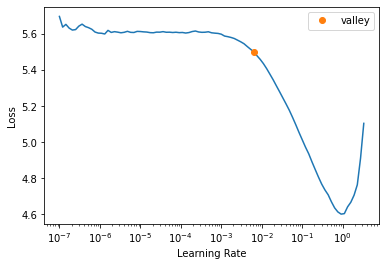

In [19]:
## takes time don't execute it
learn_lm.lr_find()

In [20]:
learn_lm.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.336798,4.874354,0.315755,00:29


In [21]:
learn_lm.fine_tune(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.840614,4.535913,0.325222,00:29


epoch,train_loss,valid_loss,accuracy,time
0,4.362096,4.196042,0.335802,00:49
1,4.180623,3.954342,0.356310,00:48
2,4.020665,3.787952,0.369765,00:49
3,3.869412,3.708294,0.381375,00:48
4,3.724890,3.657208,0.384006,00:48
5,3.593218,3.648454,0.380398,00:49
6,3.471951,3.626125,0.383653,00:48
7,3.364694,3.620962,0.383057,00:48
8,3.295199,3.626010,0.381185,00:49
9,3.219085,3.623068,0.381510,00:49


In [22]:
learn_lm.save_encoder('finetuned')

In [41]:
learn_lm.export()

In [26]:
TEXT = "Blockchain"
N_WORDS = 15
N_SENTENCES = 1
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [27]:
print("\n".join(preds))

Xxunk Newsom Recall Xxfake Newsom Recall Poll Cuomo


## Training a Classifier 

In [28]:
data_class = TextDataLoaders.from_df(posts , path = "." , text_col='posts',
                               label_col = 'class' , valid_pct = 0.2 , text_vocab=data_lm.vocab)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [29]:
data_class.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj saudi xxmaj xxunk xxmaj sports , xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk , xxunk xxmaj saudi xxunk xxunk , xxmaj xxunk xxmaj xxunk ( silver medal ) , 5 million xxmaj saudi xxunk ( $ 1 , xxrep 3 3 , xxunk ) xxunk finals xxunk home first xxmaj saudi medal xxmaj tokyo 2020 , xxunk medal history .",sports
1,xxbos xxmaj tech xxmaj giant xxmaj took $ xxunk xxmaj million xxmaj from xxmaj trump xxmaj the xxmaj day xxmaj after xxmaj jan . 6 xxmaj to xxmaj send xxmaj more xxmaj of xxmaj his xxmaj xxunk | xxmaj xxunk later xxunk violent attack xxmaj capitol . xxmaj but it ’s xxunk xxmaj trump xxunk money xxunk lies “ xxunk ” election .,politics
2,"xxbos xxmaj uber , xxmaj lyft xxmaj introduce xxmaj xxunk 22 xxmaj clone xxmaj undermine xxmaj labor xxmaj law xxmaj in xxmaj xxunk - xxmaj uber , xxmaj lyft , doordash , xxmaj xxunk xxunk past year xxunk introduce xxmaj xxunk 22 xxunk legislation . xxmaj this first ballot xxunk since xxmaj california ’s last year .",technology


In [30]:
learn_class = text_classifier_learner(data_class, AWD_LSTM, metrics=[accuracy]).to_fp16()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/autocast_mode.py:120: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [31]:
learn_class.load_encoder('finetuned')

In [32]:
learn_class.fit_one_cycle(1, 1e-2)

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.501935,0.403257,0.841962,00:22


In [33]:
learn_class.freeze_to(-2)
learn_class.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-2))

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.441471,0.322887,0.893733,00:25


In [34]:
learn_class.freeze_to(-3)
learn_class.fit_one_cycle(1, slice(5e-3/(2.6**4),1e-2))

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.410553,0.390006,0.866485,00:41


In [35]:
learn_class.unfreeze()
learn_class.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-2))

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,accuracy,time
0,0.293488,0.269727,0.901907,00:58
1,0.278827,0.286877,0.901907,00:58
2,0.248235,0.623785,0.877384,00:58
3,0.227165,0.315300,0.904632,00:58
4,0.187353,0.301992,0.899183,00:58
5,0.150709,0.330541,0.907357,00:58
6,0.123609,0.359636,0.907357,00:58
7,0.099761,0.329225,0.915531,00:59
8,0.079675,0.336617,0.918256,00:59
9,0.071486,0.334991,0.918256,00:58


In [36]:
learn_class.save('final_model_classifier')

Path('models/final_model_classifier.pth')

In [37]:
learn_class.export()

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


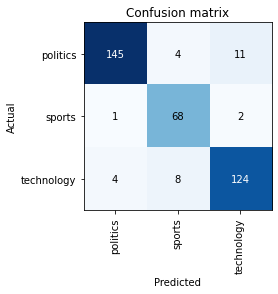

In [38]:
interp = ClassificationInterpretation.from_learner(learn_class)
interp.plot_confusion_matrix()

In [39]:
interp.most_confused()

[('politics', 'technology', 11),
 ('technology', 'sports', 8),
 ('politics', 'sports', 4),
 ('technology', 'politics', 4),
 ('sports', 'technology', 2),
 ('sports', 'politics', 1)]

In [40]:
learn_class.predict('Going live in 30 minutes  Facebook:    Youtube:   #LFG #GamblingTwitter #bettingpicks #SportsGambling #sports #sporthotpicks #getpaid #sportswagering'  )

/usr/local/lib/python3.7/dist-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


('technology', tensor(2), tensor([2.9192e-04, 2.7675e-03, 9.9694e-01]))

In [3]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

In [4]:
classifier = load_learner('reddit_classifier.pkl')

In [5]:
post ='Lionel Messi: Paris St-Germain in talks with Argentine after leaving Barcelona' 

In [6]:
classifier.predict(post)

('sports', tensor(1), tensor([4.7679e-07, 1.0000e+00, 2.7210e-07]))

In [7]:
what,_,probs =classifier.predict(post)
print(f"Post belongs to {what} category.")
print(f"Probability it's a {what}: {probs[1].item():.6f}")

Post belongs to sports category.
Probability it's a sports: 0.999999
